# Foldable Robotics final project 

### Pranay Palem, Puneet Sai Naru

![Robot body design](robot_design_new.png)


#### For more information about the background research and other files, please follow the link below
**[GitHub](https://github.com/pranaypalem/FoldableRobotics)**


## Project Goal

The primary goal of this project is to design and optimize a foldable robotic system using a four-bar mechanism. By systematically altering the lengths of the second and fourth links in the mechanism, we aim to identify the configuration that maximizes the lift provided to the robot's body. 

This project focuses on leveraging the principles of kinematic synthesis and optimization to enhance the performance of foldable robots. The challenge lies in balancing the constraints of mechanical design, material properties, and the desired lift output to achieve an efficient and effective robotic motion. 

Through this exploration, the project seeks to contribute to the broader field of foldable robotics by demonstrating how optimized four-bar configurations can be used to improve movement and functionality in lightweight, portable robotic systems.


## Challenges Faced

### 1. Difficulty in Initializing the Four-Bar Mechanism in MuJoCo

One of the significant challenges encountered during the project was building a reliable MuJoCo model for the foldable robot. To ensure proper functioning of the four-bar mechanism, it was essential to keep the links that needed to be welded in close proximity during initialization. This was crucial to prevent any initial unwanted forces from acting on the system, which could destabilize the simulation. 

However, this posed a challenge as the link lengths were continually being adjusted during the optimization process. Finding the correct angles to position and initiate the links proved to be particularly problematic. When we attempted to initialize the mechanism with a standard angle of -90 degrees for the links, the system exhibited unstable behavior, often causing the robot's body to spin uncontrollably off the ground plane. This instability highlighted the need for a more accurate method to determine the initial angles for the four-bar configuration in MuJoCo.

### 2. Solution: Determining Accurate Initial Angles

To address this issue, we developed a systematic approach to accurately initialize the four-bar mechanism:

- First, we created a simplified model of the four-bar configuration in MuJoCo, focusing solely on the mechanism itself without the robot's body.
- Next, we welded the necessary links together to form the four-bar structure. By carefully observing the simulation, we ensured the stability of the mechanism.
- Once the four-bar mechanism was formed successfully, we recorded the angles of the links in this stable configuration.
- These angles were then used as the initial angles for the next simulation, which included the four-bar mechanism integrated with the robot's body.

This approach allowed us to accurately determine the initial conditions for the simulation, ensuring stability and preventing the robot's body from spinning uncontrollably. By iterating through this process, we were able to reliably initialize the four-bar mechanism regardless of the varying link lengths, enabling further exploration and optimization of the robot's lift capabilities.


Importing Libraries

In [1]:
import os
import mujoco
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
import seaborn as sns


The functions `get_variables` and `get_variables2` are essential components of the code, designed to create the dictionaries `fourlens` and `lens`, respectively. These dictionaries act as structured repositories for storing key variables required for the simulation.

- **`get_variables`:** This function is responsible for generating the `fourlens` dictionary, which stores the lengths and parameters specific to the four-bar mechanism. By centralizing these values, it simplifies the process of referencing and modifying the parameters during the XML file creation and subsequent simulation stages.

- **`get_variables2`:** This function generates the `lens` dictionary, which organizes additional variables that are critical for defining other aspects of the robot or simulation environment. These variables may include dimensions, link properties, or other parameters necessary for building a complete and functional model.

Both dictionaries are instrumental in streamlining the integration of dynamic parameters into the XML files used in MuJoCo. Instead of manually inputting values, the functions provide a programmatic and efficient way to update and manage these variables. This not only reduces potential errors but also enhances the flexibility of the simulation setup, allowing for quick adjustments and testing of different configurations.


In [2]:
def get_variables(l1,l2,l3,l4,le):
    l1 = l1
    l2 = l2
    l3 = l3
    l4 = l4
    l5 = l1
    le = le

    
    #Variables
    
    GSM = 140 * 1e-4 # in g GSM of paper in g/cm^2
    
    b = 1e-1
    k = 1e-1
    
    
    hbody = 8 # in cm
    hbody_2 = hbody/2
    # Fourbar
    
    #Lenths
    bodyheight = 5 # in m
    w = 3 # in cm (width)
    
    h1 = bodyheight + hbody
    h1 = hbody + 0.1
    thick = 0.025  # in m
    # l1 = 5 # in cm
    # l2 = 4 # in cm # towards body
    # l3 = 3 # in cm # Up
    # l4 = 7 # in cm # towards tail
    # l5 = l1
    # le = 7 # in m
    
    ml1 = l1 * w * GSM #in g
    ml2 = l2 * w * GSM #in g
    ml3 = l3 * w * GSM #in g
    ml4 = l4 * w * GSM #in g
    ml5 = l5 * w * GSM #in g
    mle = le * w * GSM #in g
    
    #Half lengths
    l1_2 = l1/2
    l2_2 = l2/2
    l3_2 = l3/2
    l4_2 = l4/2
    l5_2 = l1_2
    le_2 = le/2
    w_2 = w/2
    
    # End Effector calc
    lex = l3 - (le_2) 
    lez = h1 + bodyheight
    
    fourlens = {
    # Fourbar
    "bodyheight": bodyheight,
    "h1": h1,
    "w": w,
    "w_2": w_2,
    "thick": thick,
    "l1": l1,
    "l2": l2,
    "l3": l3,
    "l4": l4,
    "l5": l5,
    "le": le,
    "l1_2": l1_2,
    "l2_2": l2_2,
    "l3_2": l3_2,
    "l4_2": l4_2,
    "l5_2": l5_2,
    "le_2": le_2,
    "lex": lex,
    "lez": lez,
    "ml1": ml1,
    "ml2": ml2,
    "ml3": ml3,
    "ml4": ml4,
    "ml5": ml5,
    "mle": mle,
    
    # Main Body
    "hbody" : hbody,
    "hbody_2" : hbody_2,
    "b": b,
    "k": k,
    
    }
    return fourlens



In [3]:
def get_variables2(l1,l2,l3,l4,le, average_angles):
    l1 = l1
    l2 = l2
    l3 = l3
    l4 = l4
    l5 = l1
    le = le
    average_angles = average_angles
    
    #Variables
    
    GSM = 140 * 1e-4 # in g GSM of paper in g/cm^2
    
    b = 1e-1
    k = 1e-1
    
    # Main body
    lbody1 = 6.5 # in cm
    lbody2 = 6.5 # in cm
    wbody = 7.5 # in cm
    hbody = 8 # in cm
    lleg = 2 # in cm
    lwheel = 5.6 # in cm
    
    mbody1 = 138 * 1e-3 #in g  60% of 230g  
    mbody2 = 92 * 1e-3 + 100 * 1e-3 #in g  40% of 230g
    
    lbody1_2 = lbody1/2
    lbody2_2 = lbody2/2
    lbody_offset = lbody1 + lbody2_2
    lbody_full = lbody1 + lbody2
    wbody_2 = wbody/2
    lleg_2 = lleg/2
    lwheel_2 = lwheel/2
    hbody_2 = hbody/2
    
    # Fourbar
    
    #Lenths
    bodyheight = 5 # in m
    w = 3 # in cm (width)
    
    h1 = bodyheight + hbody
    h1 = hbody + 0.1
    thick = 0.025  # in m
    
    
    ml1 = l1 * w * GSM #in g
    ml2 = l2 * w * GSM #in g
    ml3 = l3 * w * GSM #in g
    ml4 = l4 * w * GSM #in g
    ml5 = l5 * w * GSM #in g
    mle = le * w * GSM #in g
    
    #Half lengths
    l1_2 = l1/2
    l2_2 = l2/2
    l3_2 = l3/2
    l4_2 = l4/2
    l5_2 = l1_2
    le_2 = le/2
    w_2 = w/2
    
    # End Effector calc
    lex = l3 - (le_2) 
    lez = h1 + bodyheight
    
    #site
    hsite = hbody + 0.1

    lens = {
    # Fourbar
    "bodyheight": bodyheight,
    "h1": h1,
    "w": w,
    "w_2": w_2,
    "thick": thick,
    "l1": l1,
    "l2": l2,
    "l3": l3,
    "l4": l4,
    "l5": l5,
    "le": le,
    "l1_2": l1_2,
    "l2_2": l2_2,
    "l3_2": l3_2,
    "l4_2": l4_2,
    "l5_2": l5_2,
    "le_2": le_2,
    "lex": lex,
    "lez": lez,
    "ml1": ml1,
    "ml2": ml2,
    "ml3": ml3,
    "ml4": ml4,
    "ml5": ml5,
    "mle": mle,
    
    # Main Body
    "lbody1": lbody1,
    "lbody2": lbody2,
    "lleg": lleg,
    "lwheel": lwheel,
    "hbody" : hbody,
    "lbody1_2": lbody1_2,
    "lbody2_2": lbody2_2,
    "lbody_offset": lbody_offset,
    "lbody_full": lbody_full,
    "wbody_2": wbody_2,
    "hbody_2" : hbody_2,
    "lleg_2": lleg_2,
    "lwheel_2": lwheel_2,
    "mbody1": mbody1,
    "mbody2": mbody2,
    "b": b,
    "k": k,
    "hsite": hsite,


    #angles
    "average0": average_angles.iloc[0],
    "average1": average_angles.iloc[1],
    "average2": average_angles.iloc[2],
    "average3": average_angles.iloc[3],    
    }

    return lens


## `analyzeSim` Function Overview

The `analyzeSim` function is a critical component of the project, designed to analyze simulation data and evaluate the stability of the four-bar mechanism. Specifically, it checks whether the configuration being simulated results in the robot's body tipping over. The function incorporates various computational steps and visualization techniques to ensure accurate assessment.

### Function Purpose
The primary objective of `analyzeSim` is to:
1. Analyze pitch and position data from the simulation to detect instability.
2. Identify tipping conditions based on predefined thresholds for pitch and body position.
3. Provide detailed insights into the dynamics of the system through optional data visualization.

### Input Parameters
The function accepts the following inputs:
- `df`: A DataFrame containing servo control parameters (e.g., time, actual position, desired position, and torque).
- `orientation_df`: A DataFrame containing orientation data such as roll, pitch, and yaw over time.
- `plotting`: A Boolean flag to enable or disable data visualization.
- `sitePos`: A DataFrame containing position data, including the z-coordinate over time.

### Key Steps and Logic
1. **Filtering Data:**
   - The function filters `orientation_df` and `sitePos` to analyze data within a specific time window (5 to 20 seconds). This ensures that the analysis focuses on relevant segments of the simulation.

2. **Peak Detection:**
   - Using the `find_peaks` function, the code identifies peaks in the pitch data to detect significant orientation changes.
   - The first three peaks are extracted, and their values are used to calculate the average peak orientation.

3. **Tipping Conditions:**
   - The function checks whether the pitch exceeds a threshold of `0.85` radians at any point. If this condition is met, tipping is flagged.
   - Similarly, it checks whether the z-position of the body exceeds `11.8 cm`, indicating tipping.
   - An additional tipping condition checks if any of the peaks in pitch exceed `0.85` radians.
   - The `tipFlag` variable is incremented to record which condition(s) triggered the tipping detection.

4. **Visualization (Optional):**
   - If `plotting` is enabled, the function generates three plots to visualize:
     - Servo control parameters (actual vs. desired position and torque) over time.
     - Orientation data (pitch) over time.
     - Z-coordinate position over time.

5. **Output:**
   - The function returns:
     - `avg_peak`: The average of the second and third pitch peaks.
     - `tipping`: A Boolean indicating whether tipping occurred.
     - `tipFlag`: A flag encoding the tipping condition(s) triggered.

### Interpretation of Outputs
- **`avg_peak`:** Provides insight into the system's average orientation dynamics during the simulation.
- **`tipping`:** A quick indicator of whether the configuration is unstable.
- **`tipFlag`:** A detailed flag that encodes which specific conditions contributed to the instability, aiding in debugging and refinement.



In [4]:
def analyzeSim(df, orientation_df , plotting , sitePos):
    df = df
    orientation_df = orientation_df
    sitePos = sitePos
    tipping = False

    tipFlag = 0
    # filtered_df = orientation_df[orientation_df["time"] >= 5]
    # filteredSite_df = sitePos[sitePos["time"] >= 5]


    # filtered_df = orientation_df[(orientation_df["time"] >= 5) & (orientation_df["time"] <= 20)]
    # filteredSite_df = sitePos[(sitePos["time"] >= 5) & (sitePos["time"] <= 20)]

    filtered_df = orientation_df[orientation_df["time"]>=5]
    filtered_df = filtered_df[filtered_df["time"]<=20]

    filteredSite_df = sitePos[sitePos["time"] >=5]
    filteredSite_df = filteredSite_df[filteredSite_df["time"]<=20]

    
    peaks, _ = find_peaks(filtered_df["pitch"], height = 0.25 )
    first_peak_value = filtered_df.iloc[peaks[0]]["pitch"] if len(peaks) > 0 else 0
    second_peak_value = filtered_df.iloc[peaks[1]]["pitch"] if len(peaks) > 1 else 0
    third_peak_value = filtered_df.iloc[peaks[2]]["pitch"] if len(peaks) > 2 else 0

    if (filtered_df["pitch"] > 0.85).any():
        tipping = True
        tipFlag += 1
    # else:
    #     tipping = False

    if (filteredSite_df["z"] > 11.8).any():
        tipping = True
        tipFlag += 2
    # else:
    #     tipping = False

    
    avg_peak = np.mean([second_peak_value,third_peak_value])
    # tipping = any(value > 0.8 for value in [first_peak_value, second_peak_value, third_peak_value] if value is not False)

    for value in [first_peak_value, second_peak_value, third_peak_value]:
        if value is not False and value > 0.85:
            tipping = True
            tipFlag += 4
            break
    

    # print(f" first:{first_peak_value}, second:{second_peak_value} , third:{third_peak_value}")

    if plotting:
        plt.figure(figsize=(10, 6))
        plt.plot(df["time"], df["actual"], label="Actual Position")
        plt.plot(df["time"], df["desired"], label="Desired Position", linestyle='--')
        plt.plot(df["time"], df["torque"], label="Torque", linestyle=':')
        plt.xlabel("Time (s)")
        plt.ylabel("Values")
        plt.title("Servo Control Parameters vs Time")
        plt.legend()
        plt.grid()
        plt.show()


        # Plot roll, pitch, and yaw against time
        plt.figure(figsize=(10, 6))
        # plt.plot(orientation_df["time"], orientation_df["roll"], label="Roll")
        plt.plot(orientation_df["time"], orientation_df["pitch"], label="Pitch")
        # plt.plot(orientation_df["time"], orientation_df["yaw"], label="Yaw", linestyle=':')
        plt.xlabel("Time (s)")
        plt.ylabel("Orientation (radians)")
        plt.title("Orientation (Roll, Pitch, Yaw) vs Time")
        plt.legend()
        plt.grid()
        plt.show()

        # Plot z values against time
        plt.figure(figsize=(10, 6))
        plt.plot(sitePos["time"], sitePos["z"], label="Z Position", color="blue")
        plt.xlabel("Time (s)")
        plt.ylabel("Z Position (cm)")
        plt.title("Z Position vs Time")
        plt.legend()
        plt.grid()
        plt.show()
            
    return avg_peak , tipping , tipFlag
    

## Motor Modeling

Motor modeling is a crucial step in understanding and simulating the behavior of the SG90 servo motor used in the project. This process involved both theoretical calculations and educated assumptions, as detailed manufacturer specifications and precise testing equipment (e.g., an oscilloscope or current meter) were unavailable. Despite these limitations, several key motor parameters were estimated based on datasheets and common characteristics of similar servo motors.

### Assumptions and Data Sources
- **Datasheets as Reference:** Multiple datasheets from different manufacturers were reviewed to identify common parameters. While variations exist among SG90 servos, most performance data was consistent across sources.
- **Nominal Voltage:** The motor's nominal operating voltage was assumed to be **6 volts**, which is standard for SG90 servos.
- **Stall Torque:** Datasheets listed a range of stall torque values, with many around **15 N-cm (0.15 N-m)**. This was taken as a reliable estimate.
- **Gear Ratio:** One datasheet specified a gear ratio of **55.5**, which was used to calculate the motor's stall torque.
- **Stall Current:** Manufacturers listed a maximum current range between **550 mA and 650 mA**, interpreted as the stall current. A value of **600 mA** was assumed for calculations.


In [5]:
Vnom = 6 #Nominal Voltage
G = 55.5 #gear ratio
t_stall = 15/100/G
i_stall = .6
R = Vnom/i_stall
i_nl = .2
w_nl = .66*1000*2*math.pi/180*G
kt = t_stall/ i_stall
kv= Vnom/w_nl
ke = kt
b = kt*i_nl/w_nl
ts = 1e-4 #Time Step
V_control = 5
b_fit = 1.404e-6  ##b_act in the runsim code
kp_fit = 8.896 ##Used as kp below in runsim code

kp = 20
b_act = 1.404e-2

## `calculate_orientation` Function Overview

The `calculate_orientation` function is designed to calculate the roll, pitch, and yaw of a system based on data from an Inertial Measurement Unit (IMU). This function integrates data from accelerometer, gyroscope, and magnetometer sensors to estimate the orientation of the system over time. The approach combines sensor data using complementary filtering to provide a robust and stable orientation estimation.

### Inputs
The function accepts the following inputs:
- **`accel` (array):** Accelerometer readings along the $x$, $y$, and $z$ axes.
- **`gyro` (array):** Gyroscope readings (angular velocity) along the $x$, $y$, and $z$ axes.
- **`mag` (array):** Magnetometer readings (magnetic field strength) along the $x$, $y$, and $z$ axes.
- **`dt` (float):** Time step between successive readings, used for gyroscope integration.
- **`prev_angles` (tuple):** The previous orientation angles $(\text{roll}, \text{pitch}, \text{yaw})$ used as a starting point for calculations.

### Outputs
The function returns:
- **`roll` (float):** The rotation angle around the $x$-axis (tilt).
- **`pitch` (float):** The rotation angle around the $y$-axis (elevation).
- **`yaw` (float):** The rotation angle around the $z$-axis (heading).

### Key Steps and Logic

#### 1. **Accelerometer-Based Estimation**
The accelerometer is used to estimate the roll and pitch angles based on gravitational acceleration:
- **Roll (`roll_acc`):**  
  Calculated using the arctangent of the ratio of the $y$ and $z$ accelerations:  
  $$
  \text{roll\_acc} = \arctan2(\text{accel}[1], \text{accel}[2])
  $$
- **Pitch (`pitch_acc`):**  
  Calculated using the arctangent of the negative $x$ acceleration divided by the magnitude of the $y$ and $z$ components:  
  $$
  \text{pitch\_acc} = \arctan2(-\text{accel}[0], \sqrt{\text{accel}[1]^2 + \text{accel}[2]^2})
  $$

#### 2. **Magnetometer-Based Estimation**
The magnetometer is used to calculate the yaw angle based on the magnetic field readings:
- Magnetic field components ($B_x$, $B_y$) are adjusted using the estimated roll and pitch from the accelerometer.
- **Yaw (`yaw_mag`):**  
  Calculated using the arctangent of the ratio of the adjusted magnetic field components:
  $$
  \text{yaw\_mag} = \arctan2(-\text{By}, \text{Bx})
  $$

#### 3. **Gyroscope Integration**
The gyroscope provides angular velocity, which is integrated over time ($dt$) to estimate orientation changes:
- **Roll (`roll_gyro`):**  
  $$
  \text{roll\_gyro} = \text{prev\_roll} + \text{gyro}[0] \cdot dt
  $$
- **Pitch (`pitch_gyro`):**  
  $$
  \text{pitch\_gyro} = \text{prev\_pitch} + \text{gyro}[1] \cdot dt
  $$
- **Yaw (`yaw_gyro`):**  
  $$
  \text{yaw\_gyro} = \text{prev\_yaw} + \text{gyro}[2] \cdot dt
  $$

#### 4. **Complementary Filter**
To combine the benefits of each sensor type (low noise from accelerometers and magnetometers, and high responsiveness from gyroscopes), a complementary filter is applied:
- The filter uses a weighting factor $\alpha$ to blend the accelerometer/magnetometer estimates with the gyroscope integration:
  - **Roll:**  
    $$
    \text{roll} = \alpha \cdot \text{roll\_gyro} + (1 - \alpha) \cdot \text{roll\_acc}
    $$
  - **Pitch:**  
    $$
    \text{pitch} = \alpha \cdot \text{pitch\_gyro} + (1 - \alpha) \cdot \text{pitch\_acc}
    $$
  - **Yaw:**  
    $$
    \text{yaw} = \alpha \cdot \text{yaw\_gyro} + (1 - \alpha) \cdot \text{yaw\_mag}
    $$

### Advantages of the Approach
1. **Noise Reduction:**  
   The complementary filter balances noisy but stable accelerometer/magnetometer data with responsive but drift-prone gyroscope data.
   
2. **Real-Time Performance:**  
   The function operates efficiently, making it suitable for real-time orientation tracking in robotics or embedded systems.
   
3. **Robustness:**  
   By fusing multiple sensor modalities, the function provides a more reliable orientation estimate compared to using a single sensor.


In [6]:
def calculate_orientation(accel, gyro, mag, dt, prev_angles):
    # Unpack previous angles
    prev_roll, prev_pitch, prev_yaw = prev_angles

    # Accelerometer-based pitch and roll
    roll_acc = np.arctan2(accel[1], accel[2])
    pitch_acc = np.arctan2(-accel[0], np.sqrt(accel[1]**2 + accel[2]**2))
    
    # Magnetometer-based yaw
    Bx = mag[0] * np.cos(pitch_acc) + mag[1] * np.sin(roll_acc) * np.sin(pitch_acc) + mag[2] * np.cos(roll_acc) * np.sin(pitch_acc)
    By = mag[1] * np.cos(roll_acc) - mag[2] * np.sin(roll_acc)
    yaw_mag = np.arctan2(-By, Bx)
    
    # Gyroscope integration
    roll_gyro = prev_roll + gyro[0] * dt
    pitch_gyro = prev_pitch + gyro[1] * dt
    yaw_gyro = prev_yaw + gyro[2] * dt
    
    # Complementary filter
    alpha = 0.98
    roll = alpha * roll_gyro + (1 - alpha) * roll_acc
    pitch = alpha * pitch_gyro + (1 - alpha) * pitch_acc
    yaw = alpha * yaw_gyro + (1 - alpha) * yaw_mag
    
    return roll, pitch, yaw

## Explanation of `servoControl` Function

The `servoControl` function is used to control the behavior of a servo motor during simulation. The servo's desired angle is dynamically adjusted, and relevant data such as time, desired angle, actual angle, and torque is logged for analysis. Below is a breakdown of the key components and working of the function:

### Key Components

1. **Sine Wave Parameters**:
   - **Amplitude**: Controls the maximum deviation of the sine wave from zero.
   - **Frequency**: Determines how many oscillations occur per second, defined in Hertz (Hz).
   - **Start Time**: Specifies the time after which the sine wave behavior begins.

2. **Log Data Dictionary**:
   - The dictionary `log_data` stores time-series data for simulation analysis.
   - Keys include:
     - `time`: Simulation timestamps.
     - `actual`: Actual angle of the servo motor.
     - `desired`: Target angle of the servo motor.
     - `torque`: Torque applied to achieve the desired angle.

3. **Desired Angle Logic**:
   - The desired angle (`desired`) changes based on the simulation time (`data.time`).
   - **Before Start Time**: Desired angle is set to `0`.
   - **Between 1s and 4.8s**: Desired angle is fixed at `-0.4`.
   - **After Start Time**: Desired angle follows a sine wave pattern:
     \[
     \text{desired} = \text{amplitude} \cdot \sin(2 \pi \cdot \text{frequency} \cdot (\text{data.time} - \text{start\_time}))
     \]

4. **Data Logging**:
   - Simulation data is appended to `log_data` at each timestep for post-simulation analysis.

### Working

1. **Initialization**:
   - Amplitude, frequency, and start time for the sine wave are initialized.

2. **Simulation Execution**:
   - For each simulation timestep:
     - The `time`, `actual`, `desired`, and `torque` are appended to the `log_data` dictionary.
     - The desired angle is updated based on the time-based conditions:
       - A fixed value of `-0.4` is used within the time window [1s, 4.8s].
       - A sine wave pattern is followed after the specified start time.

3. **Sine Wave Dynamics**:
   - The sine wave's amplitude and frequency define the smooth oscillatory behavior of the servo's desired angle after the start time. The sine function introduces a natural and predictable motion pattern.

4. **Logging for Analysis**:
   - Collected data is structured for visualization or further processing to evaluate the servo motor's performance under the simulation conditions.



In [7]:
def servoControl(model, data):
    
    # log_data = log_data
    global log_data  # Use the global DataFrame dictionary
    
    w = data.qvel[model.joint("joint_overlap").id]  # Angular velocity
    actual = data.qpos[model.joint("joint_overlap").id]  # Current position

    # Desired angle follows a sine wave
    amplitude = 1  # Amplitude of the sine wave
    frequency = 0.15  # Frequency in Hz
    start_time = 5

    if data.time > 1 and data.time < 4.8:
        desired = -0.4
    if data.time > start_time :
        desired = amplitude * math.sin(2 * math.pi * frequency * (data.time-start_time))
    else:
        desired = 0

    error = desired - actual
    V = kp * error
    # if V > V_control:
    #     V = V_control
    # if V < -V_control:
    #     V = -V_control

    torque = (kt * (V - (ke) * w * G) / R - b_act * w * G) * G
    
    data.ctrl[0] = torque
    data.ctrl[1] = -0.2 # make the robot move back slowly 

    # Log the data into the dictionary
    log_data["time"].append(data.time)
    log_data["actual"].append(actual)
    log_data["desired"].append(desired)
    log_data["torque"].append(torque)
    
    # print(torque)

def save_log_to_dataframe():
    df = pd.DataFrame(log_data)
    return df

## Four-Bar Mechanism XML Template

The provided XML template defines a simulation environment for a four-bar mechanism using MuJoCo. This template specifies various components such as the visual settings, dynamics, and physical structure of the mechanism. Below is a detailed explanation of the key components and their roles:

---

### Key Sections

1. **`<visual>`**
   - Defines visual settings for the simulation environment.
   - Parameters include:
     - `offwidth` and `offheight`: Set the resolution of the simulation rendering.

2. **`<option>`**
   - Configures simulation options:
     - `gravity`: Gravity vector is set to zero for a zero-gravity simulation.
     - `timestep`: Specifies the time increment for simulation steps (0.002 seconds).
     - `iterations` and `tolerance`: Parameters for numerical integration accuracy.
     - `integrator`: Uses the `RK4` method for integration, providing smooth dynamics.
     - `contact="disable"`: Disables collision detection for simulation simplicity.

3. **`<compiler>`**
   - Sets compiler options:
     - `angle="degree"`: Specifies that angles in the model are in degrees.

4. **`<worldbody>`**
   - Defines the physical world and components of the simulation:
     - **Lights**: Three directional lights illuminate the scene.
     - **Plane (Ground)**: A flat plane serves as the base for the simulation.
     - **Four-Bar Body**: Composed of interconnected links with joints:
       - `4base`: Base link, serves as the starting point of the four-bar mechanism.
       - `link_right`, `link_up`, `link_left`, `link_overlap`: Links forming the mechanism, each defined with dimensions (`size`), position (`pos`), and material properties (e.g., `mass`).
       - **Joints**: Hinge joints connect the links, allowing rotation with specified limits (`range`), damping (`damping`), and stiffness (`stiffness`).
     - **End Effector (EEbar)**: Represents the movable end of the mechanism.

5. **`<equality>`**
   - Ensures constraints between specific bodies in the simulation:
     - **Weld Constraints**:
       - `weld1`: Welds the `4base` and `link_overlap` to ensure fixed relative positioning.
       - `weld2`: Welds the `link_right` and `EEbar` for precise alignment.

---

### Dynamic Parameters
- **Geometric Dimensions**:
  - `{l1_2}`, `{l2_2}`, `{l3_2}`, `{l4_2}`, `{l5_2}`: Half-lengths of the links.
  - `{w_2}`: Half-width of the links.
  - `{thick}`: Thickness of the links.
  - `{le_2}`: Half-length of the end effector.

- **Mass Properties**:
  - `{ml1}`, `{ml2}`, `{ml3}`, `{ml4}`, `{ml5}`: Mass values for each link.

- **Joint Properties**:
  - `{b}`: Damping coefficient, simulating resistance in joint motion.
  - `{k}`: Stiffness coefficient, simulating joint elasticity.

- **End Effector Position**:
  - `{lez}`: Vertical position of the end effector.

---


In [8]:
four_template = '''
<mujoco>
    <visual>
        <global offwidth="800" offheight="600" />
        
    </visual>
    
    <option gravity="0 0 0" timestep="0.002" iterations="200" tolerance="1e-10" integrator="RK4">
        <flag contact="disable"/>
    </option>
    
    <compiler angle="degree"/>
    
    <worldbody>
        <!-- Lights -->
        <light name="Light1" pos="0 40 80"/>
        <light name="Light2" pos="-20 -40 80"/>
        <light name="Light3" pos="30 0 80"/>
        
        <!-- Plane (Ground) -->
        <geom type="plane" size="50 50 0.1" pos="0 0 -1" rgba="1 1 1 1"/>
            
            <!-- 4 Bar Body -->
            <body name="4base" pos="0 0 {h1}">
                <geom type="box" size="{l1_2} {w_2} {thick}" pos="{l1_2} 0 0" rgba="1 1 0 1" mass="{ml1}"/>
                <body name="link_right" pos="{l1} 0 0" axisangle="0 1 0 -90">
                    <geom type="box" size="{l2_2} {w_2} {thick}" pos="{l2_2} 0 0" rgba="1 1 0 1" mass="{ml2}"/>
                    <joint name="joint_right" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-70 70"/>
                    <body name="link_up" pos="{l2} 0 0" axisangle="0 1 0 -90">
                        <geom type="box" size="{l3_2} {w_2} {thick}" pos="{l3_2} 0 0" rgba="1 0 0 1" mass="{ml3}"/>
                        <joint name="joint_up" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-90 90"/>
                        <body name="link_left" pos="{l3} 0 0" axisangle="0 1 0 -90">
                            <geom type="box" size="{l4_2} {w_2} {thick}" pos="{l4_2} 0 0" rgba="1 1 0 1" mass="{ml4}"/>
                            <joint name="joint_left" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-90 90"/>
                            <body name="link_overlap" pos="{l4} 0 0" axisangle="0 1 0 -90">
                                <geom type="box" size="{l5_2} {w_2} {thick}" pos="{l5_2} 0 0" rgba="1 0 1 1" mass="{ml5}"/>
                                <joint name="joint_overlap" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-70 70"/>
                            </body>
                        </body>
                    </body>
                </body>
            </body> 
        

        <!-- End Effector bar -->
        <body name="EEbar" pos="{l1} 0 {lez}">
            <geom type="box" size="{thick} {w_2} {le_2}" pos="0 0 {le_2}" rgba="0 1 0 1" mass="0.01"/>
            <joint type="free"/> 
        </body>
        
        

    </worldbody>

    <equality>
        <weld name="weld1" active="true" body1="4base" body2="link_overlap" relpose="0 0 0 1 0 0 0" solimp="0.99 0.99 0.001 0.5 1" solref="0.002 1"/>
        <weld name="weld2" active="true" body1="link_right" body2="EEbar" relpose="0 0 -0.025 0.707 0  0.707 0" solimp="0.99 0.99 0.001 0.5 1" solref="0.002 1"/>

    </equality>
    
</mujoco>

'''

## Full body XML Template

This XML template defines a simulation environment for the full robot body using MuJoCo. The model incorporates multiple components such as a base body, a four-bar linkage system, a wheel mechanism, and an end effector, along with sensors and actuators for interaction and control. Below is a detailed breakdown of the template's components and their functionality:

---

### Key Sections

1. **`<visual>`**
   - Sets up the visual environment for the simulation.
   - Parameters include:
     - `offwidth` and `offheight`: Specify rendering resolution.

2. **`<option>`**
   - Configures simulation options:
     - `gravity`: Gravity vector is set to simulate Earth's gravity.
     - `timestep`: The time increment for simulation steps (0.002 seconds).
     - `integrator`: Uses the `RK4` method for precise dynamics integration.
     - `contact="enable"`: Enables collision detection.

3. **`<compiler>`**
   - Configures the angle unit for the model:
     - `angle="degree"`: All angles are expressed in degrees.

4. **`<worldbody>`**
   - Defines the physical world and components of the simulation:
     - **Lights**: Three lights illuminate the scene.
     - **Plane (Ground)**: A flat plane acts as the ground.
     - **Main Composite Body**:
       - Contains two box geometries (`body1` and `body2`) with their respective dimensions and positions.
       - An IMU (Inertial Measurement Unit) site is attached for sensor data collection.
       - **Legs and Wheels**:
         - Legs are a fixed geometry extending downward.
         - Wheels are represented as cylindrical geometries, with a hinge joint for rotation.
       - **Mount**: A fixed structure attached to the main body.
     - **Four-Bar Linkage System**:
       - Composed of interconnected links (`4base`, `link_right`, `link_up`, `link_left`, `link_overlap`) with hinge joints allowing rotation.
       - Joint properties include stiffness (`stiffness`), damping (`damping`), and motion limits (`range`).
     - **End Effector (EEbar)**:
       - A movable component representing the functional endpoint of the mechanism.
       - Includes a free joint for dynamic interaction.

5. **`<equality>`**
   - Specifies constraints between components:
     - **Weld Constraints**:
       - `weld1`: Fixes the position of the `4base` and `link_overlap`.
       - `weld2`: Fixes the alignment of `link_right` and `EEbar`.

6. **`<contact>`**
   - Excludes collision detection between specific components:
     - Excludes contact between `Main` and `Wheels`.

7. **`<actuator>`**
   - Defines actuators for controlling joints:
     - `servo_1`: Controls the `joint_overlap` with a gear ratio of 55.
     - `wheels`: Controls the wheel joint with a gear ratio of 10, limited to a range of `[-1, 1]`.

8. **`<sensor>`**
   - Adds sensors for collecting environmental and dynamic data:
     - **IMU Sensors**:
       - `accelerometer`: Measures linear acceleration.
       - `gyro`: Measures angular velocity.
       - `magnetometer`: Measures magnetic field.

---

### Dynamic Parameters
- **Geometric Dimensions**:
  - `{lbody1_2}`, `{lbody2_2}`, `{wbody_2}`, `{hbody_2}`: Half-length, width, and height for body geometries.
  - `{lleg_2}`: Half-length of the leg geometry.
  - `{lwheel_2}`: Half-length of the wheel geometry.

- **Four-Bar Linkage**:
  - `{l1_2}`, `{l2_2}`, `{l3_2}`, `{l4_2}`, `{l5_2}`: Half-lengths of the linkage components.
  - `{thick}`, `{w_2}`: Thickness and width of the linkages.
  - `{lez}`: Vertical position of the end effector.

- **Mass Properties**:
  - `{mbody1}`, `{mbody2}`, `{ml1}`, `{ml2}`, `{ml3}`, `{ml4}`, `{ml5}`: Mass values for respective components.

- **Joint Properties**:
  - `{b}`: Damping coefficient.
  - `{k}`: Stiffness coefficient.
  - `{average0}`, `{average1}`, `{average2}`, `{average3}`: Orientation angles for linkage joints.

---



In [9]:
xml_template = '''
<mujoco>
    <visual>
        <global offwidth="800" offheight="600" />
        
    </visual>
    
    <option gravity="0 0 -9.81" timestep="0.002" iterations="200" tolerance="1e-10" integrator="RK4">
        <flag contact="enable"/>
    </option>
    
    <compiler angle="degree"/>
    
    <worldbody>
        <!-- Lights -->
        <light name="Light1" pos="0 40 80"/>
        <light name="Light2" pos="-20 -40 80"/>
        <light name="Light3" pos="30 0 80"/>
        
        <!-- Plane (Ground) -->
        <geom type="plane" size="50 50 0.1" pos="0 0 -1" rgba="1 1 1 1"/>

        <!-- Single Composite Body -->
        <body name="Main" pos="0 0 {bodyheight}">
            <geom type="box" size="{lbody1_2} {wbody_2} {hbody_2}" pos="{lbody1_2} 0 {hbody_2}" rgba="1 0 0 1" mass="{mbody1}"/>
            <geom type="box" size="{lbody2_2} {wbody_2} {hbody_2}" pos="{lbody_offset} 0 {hbody_2}" rgba="0 1 0 1" mass="{mbody2}"/>
            <!-- <geom type="box" size="0.1 0.1 0.1" pos="{lbody_offset} 0 {hbody}" rgba="0 0 1 1" mass="0.01"/> -->
            <site name="imu_site" pos="{lbody_offset} 0 {hsite}" size="1" rgba="1 0 0 1"/>
            <joint type="free"/>
            <body name="Legs" pos="{lbody_full} 0 0">
                <geom type="box" size="1 {wbody_2} {lleg_2}" pos="0 0 -{lleg_2}" rgba = "0 0 1 1" mass="0" friction="0 0 0"/>
            </body>
            <body name="Wheels" pos="1 0 1">
                <geom type="cylinder" size="{lwheel_2} {wbody_2}" quat="0.707 0.707 0 0" rgba = "0 0 1 1" mass="0.015"/>
                <joint name="wheel_joint" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}"/>

            </body>
            <body name="Mount" pos="0 0 {hbody}">
                <geom type="box" size="1 1.5 0.025" pos=" 0.5 0 0 " rgba = "1 0 1 1" mass="0"/>
            </body>
            
            <!-- 4 Bar Body -->
            <body name="4base" pos="0 0 {h1}">
                <geom type="box" size="{l1_2} {w_2} {thick}" pos="{l1_2} 0 0" rgba="1 1 0 1" mass="{ml1}"/>
                <body name="link_right" pos="{l1} 0 0" axisangle="0 1 0 {average0}">
                    <geom type="box" size="{l2_2} {w_2} {thick}" pos="{l2_2} 0 0" rgba="1 1 0 1" mass="{ml2}"/>
                    <joint name="joint_right" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-70 70"/>
                    <body name="link_up" pos="{l2} 0 0" axisangle="0 1 0 {average1}">
                        <geom type="box" size="{l3_2} {w_2} {thick}" pos="{l3_2} 0 0" rgba="1 0 0 1" mass="{ml3}"/>
                        <joint name="joint_up" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-90 90"/>
                        <body name="link_left" pos="{l3} 0 0" axisangle="0 1 0 {average2}">
                            <geom type="box" size="{l4_2} {w_2} {thick}" pos="{l4_2} 0 0" rgba="1 1 0 1" mass="{ml4}"/>
                            <joint name="joint_left" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-90 90"/>
                            <body name="link_overlap" pos="{l4} 0 0" axisangle="0 1 0 {average3}">
                                <geom type="box" size="{l5_2} {w_2} {thick}" pos="{l5_2} 0 0" rgba="1 0 1 1" mass="{ml5}"/>
                                <joint name="joint_overlap" axis="0 1 0" type="hinge" pos="0 0 0" damping="{b}" stiffness="{k}" limited="true" range="-70 70"/>
                            </body>
                        </body>
                    </body>
                </body>
            </body> 
            
            
        </body>

        <!-- End Effector bar -->
        <body name="EEbar" pos="{l1} 0 {lez}">
            <geom type="box" size="{thick} {w_2} {le_2}" pos="0 0 {le_2}" rgba="0 1 0 1" mass="0.01"/>
            <joint type="free"/> 
        </body>
        
        

    </worldbody>

    <equality>
        <weld name="weld1" active="true" body1="4base" body2="link_overlap" relpose="0 0 0 1 0 0 0" solimp="0.99 0.99 0.001 0.5 1" solref="0.002 1"/>
        <weld name="weld2" active="true" body1="link_right" body2="EEbar" relpose="0 0 -0.025 0.707 0  0.707 0" solimp="0.99 0.99 0.001 0.5 1" solref="0.002 1"/>

    </equality>

    <contact>
       
        <exclude body1="Main" body2="Wheels"/>
    
    </contact>

    <actuator>
    
        <motor name="servo_1" joint="joint_overlap" gear="55"/>
        <motor name="wheels" joint="wheel_joint" gear="10" ctrllimited="true" ctrlrange="-1 1" />
        
    </actuator>

    <sensor>
        <accelerometer name="imu_accel" site="imu_site"/>
        <gyro name="imu_gyro" site="imu_site"/>
        <magnetometer name="imu_mag" site="imu_site"/>
    </sensor>

    
</mujoco>

'''

## The `run_sim` Function

The `run_sim` function is the core simulation routine designed to test various configurations of a mechanical system in MuJoCo. This function performs simulation initialization, data collection, and result analysis. It also supports optional video visualization and data plotting. Below is a detailed explanation of its components and workflow:

---

### Function Parameters
- `l1, l2, l3, l4, le`: Geometric parameters representing the lengths and dimensions of the system components.
- `show_video`: A boolean flag to display a video of the simulation. Default is `False`.
- `plotting`: A boolean flag to enable or disable data plotting during analysis. Default is `False`.

---

### Key Steps and Components

#### 1. **Simulation Initialization**
- **Four-Bar Linkage**:
  - `get_variables` is used to calculate the parameters for the four-bar mechanism.
  - The mechanism is initialized using the `four_template` XML template.
  - MuJoCo's `MjModel`, `MjData`, and `Renderer` are set up for simulation.

---

#### 2. **First Simulation: Four-Bar Analysis**
- **Duration and Framerate**:
  - Simulates the system for `5 seconds` at `30 Hz`.

- **Angle Collection**:
  - Collects joint angles (`qpos`) between 1.0s and 1.001s for detailed analysis.
  - The average angles are computed in degrees and adjusted by subtracting 90° for reference.

- **Average Angles**:
  - The computed averages are used to refine the system parameters with `get_variables2`.

---

#### 3. **Second Simulation: Full Model with Control**
- **XML Generation**:
  - The full system XML is constructed using the computed parameters and `xml_template`.

- **Orientation Sensors**:
  - Accelerometer, gyroscope, and magnetometer readings are used to compute roll, pitch, and yaw.

- **Site Position Logging**:
  - The position of a designated site (`site_xpos`) is tracked during the simulation.

- **Servo Control**:
  - `servoControl` is used to dynamically control the system during the simulation.

- **Duration and Framerate**:
  - Simulates the system for `30 seconds` at `30 Hz`.

- **Video Rendering**:
  - Captures frames for video playback if `show_video` is `True`.

---

#### 4. **Data Logging and Analysis**
- **DataFrames**:
  - Logs are saved into pandas DataFrames for orientation (`orientation_log`), site positions (`sitePos`), and general simulation data (`log_data`).

- **Analysis**:
  - `analyzeSim` is used to compute:
    - `avg`: Average performance metric.
    - `tipping`: Whether the system tipped over.
    - `Flag`: Additional analysis flag.

- **Tipping Adjustment**:
  - If the system tips over, `avg` is set to `-1`.

---

### Outputs
- **`avg`**: The performance metric of the system.
- **`Flag`**: A flag indicating analysis results.

---

### Features
1. **Dynamic System Configuration**:
   - The function adapts to different geometries and configurations.

2. **Integrated Sensors**:
   - Accelerometer, gyroscope, and magnetometer readings for orientation analysis.

3. **Data Logging**:
   - Comprehensive logging of time, position, and orientation data.

4. **Video Playback**:
   - Optional rendering and playback of simulation frames.

5. **Tipping Analysis**:
   - Detects and penalizes system tipping events.

---

In [10]:
def run_sim(l1,l2,l3,l4,le,show_video=False , plotting = False):

    global log_data  # Use the global DataFrame dictionary
    global orientation_log  # Use the global DataFrame dictionary
    plotting = plotting
    
    fourlens = get_variables(l1,l2,l3,l4,le)
    fourxml = four_template.format(**fourlens)
    
    model = mujoco.MjModel.from_xml_string(fourxml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model,width=800,height=600)
    mujoco.mj_resetData(model,data)

    frames = []
    duration = 5 # (seconds)
    framerate = 30 # (Hz)

    
    # Initialize an empty list to store the angles
    angles_data = []
    
    while data.time < duration:
        mujoco.mj_step(model, data)
    
        # Collect angles between 1 and 1.5 seconds
        if data.time > 1 and data.time < 1.001:
            angles_data.append({
                "angle_0": data.qpos[0],
                "angle_1": data.qpos[1],
                "angle_2": data.qpos[2],
                "angle_3": data.qpos[3],
                "angle_4": data.qpos[4]
            })
    
        if len(frames) < data.time * framerate:
            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)
    
    # Convert the collected angles to a pandas DataFrame
    angles_df = pd.DataFrame(angles_data)
    
    # Calculate the average of each angle
    average_angles = angles_df.mean()
    average_angles = np.degrees(average_angles)
    average_angles = average_angles - 90
    
    # # Display the results
    # print("Average Angles:")
    # for angle, avg in average_angles.items():
    #     print(f"{angle}: {avg}")

    del model,data,renderer

    lens = get_variables2(l1,l2,l3,l4,le, average_angles)
    
    
    # log_data = {
    # "time": [],
    # "actual": [],
    # "desired": [],
    # "torque": []
    # }

    # orientation_log = {
    #     "time": [],
    #     "roll": [],
    #     "pitch": [],
    #     "yaw": []
    # }

    roll, pitch, yaw = 0.0, 0.0, 0.0
    dt = 1 / framerate  # Time step
    
    xml = xml_template.format(**lens)
    # xml = xmlfull_template.format(main_body = main_body , four_bar = four_bar)

    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model,width=800,height=600)
    mujoco.mj_resetData(model,data)

    frames = []
    duration = 30 # (seconds)
    framerate = 30 # (Hz)

    site_name = "site_name_here"

    # Get the ID of the site
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, site_name)
    
    
    try:
        mujoco.set_mjcb_control(servoControl)
    
    
        while data.time < duration:
            mujoco.mj_step(model, data)
            
            accel = data.sensordata[:3]
            gyro = data.sensordata[3:6]
            mag = data.sensordata[6:9]
        
            roll, pitch, yaw = calculate_orientation(accel, gyro, mag, dt, (roll, pitch, yaw))


            # Get the position of the site (xpos)
            
            site_xpos = data.site_xpos[site_id]
            
            sitePos["time"].append(data.time)
            sitePos["x"].append(site_xpos[0])
            sitePos["y"].append(site_xpos[1])
            sitePos["z"].append(site_xpos[2])
            
            # Log the data
            orientation_log["time"].append(data.time)
            orientation_log["roll"].append(roll)
            orientation_log["pitch"].append(pitch)
            orientation_log["yaw"].append(yaw)
        
            # Print or log the values
            # print(f"Time: {data.time:.2f}, Roll: {roll:.2f}, Pitch: {pitch:.2f}, Yaw: {yaw:.2f}")
        
            if len(frames) < data.time * framerate:
                renderer.update_scene(data)
                pixels = renderer.render()
                frames.append(pixels)

        if show_video:
            media.show_video(frames, fps=framerate,width = 800 ,height = 600)

    finally:
        mujoco.set_mjcb_control(None)

    df = save_log_to_dataframe()
    orientation_df = pd.DataFrame(orientation_log)
    sitePos_df = pd.DataFrame(sitePos)

    avg, tipping , Flag = analyzeSim(df, orientation_df , plotting, sitePos_df)

    if tipping:
        avg = -1

    del model,data,renderer

    
    return avg, Flag

        

#### Test run of the simulation with initial values given

`l2` =  5, `l4` = 5

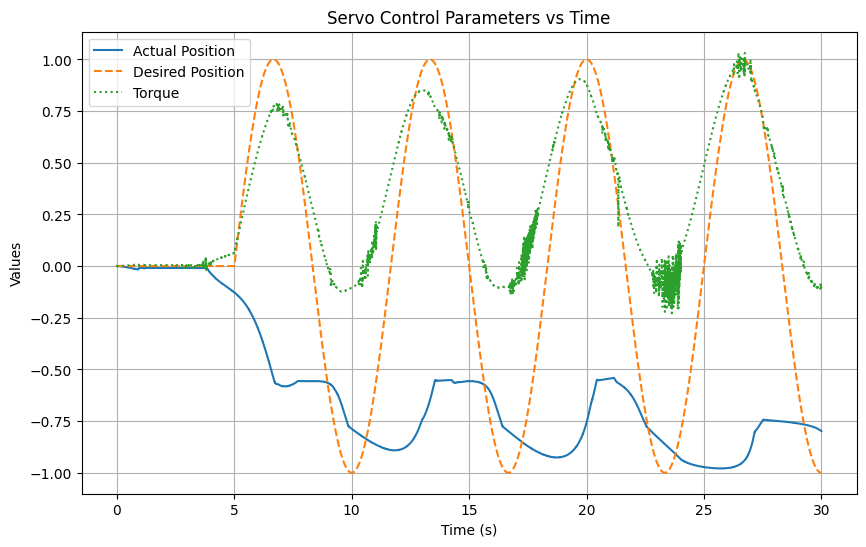

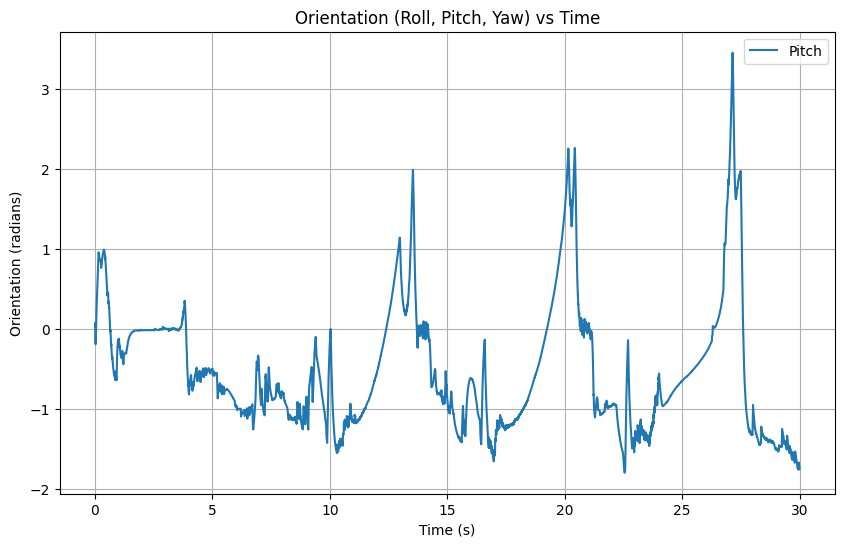

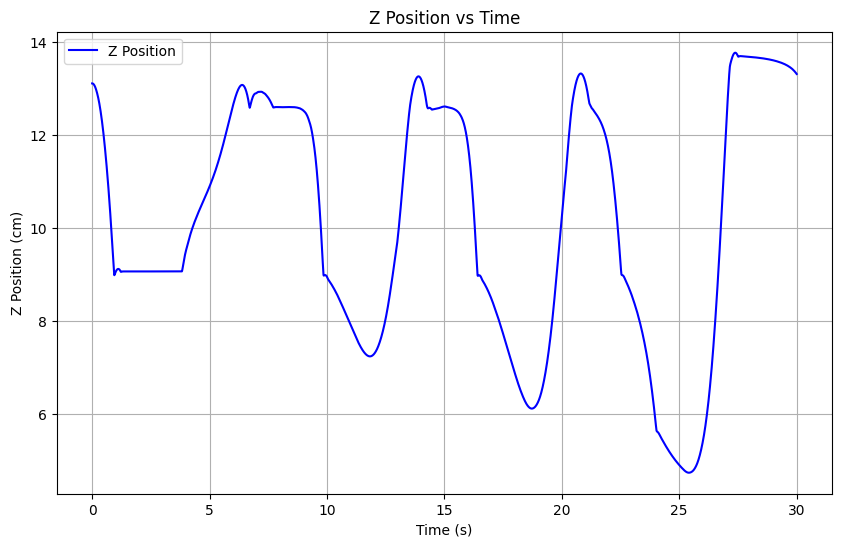

In [11]:
log_data = {
    "time": [],
    "actual": [],
    "desired": [],
    "torque": []
    }

orientation_log = {
        "time": [],
        "roll": [],
        "pitch": [],
        "yaw": []
    }

sitePos = {
    "time": [],
    "x": [],
    "y": [],
    "z": []
}

runtime_avg , Flag = run_sim(l1 = 5 , l2 = 5, l3 = 6, l4 = 5, le = 10, show_video= True, plotting = True)

`l2` =  4, `l4` = 6

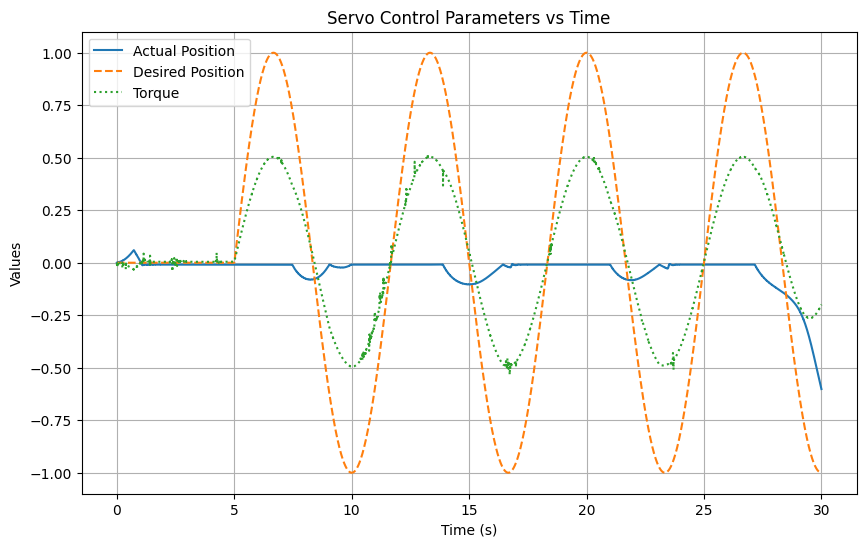

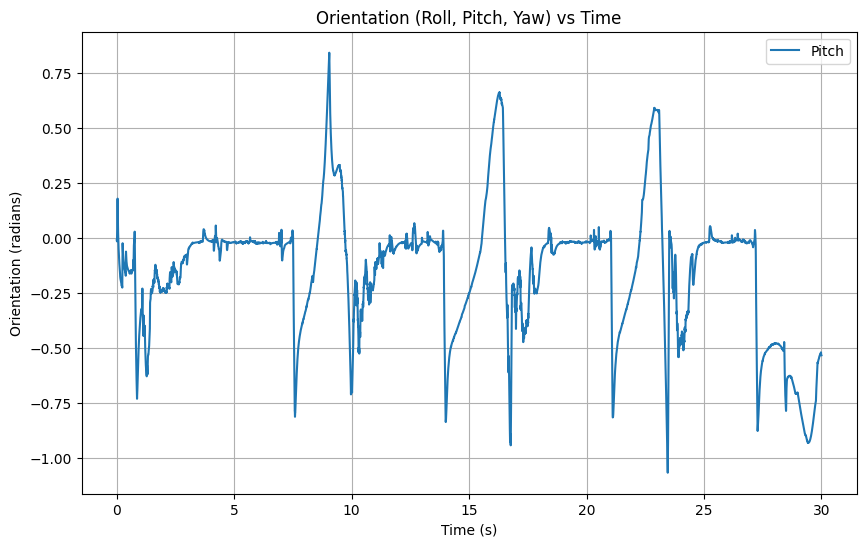

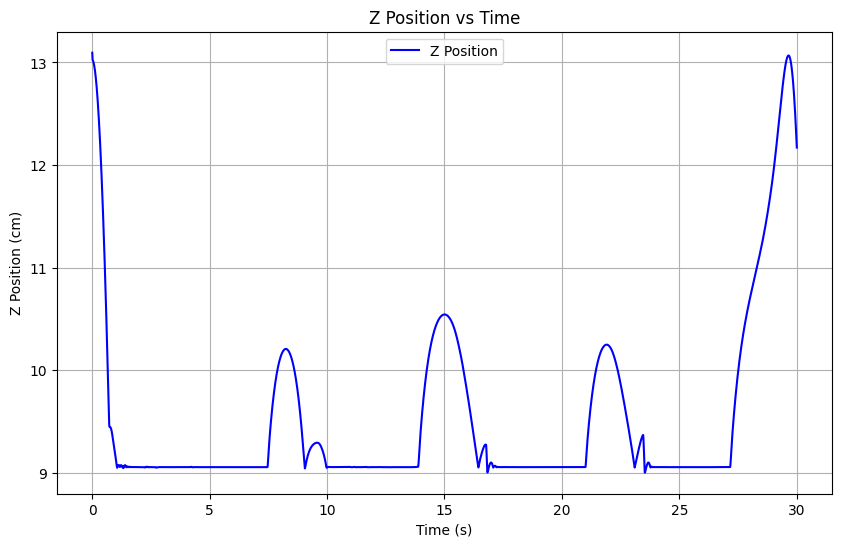

In [12]:
log_data = {
    "time": [],
    "actual": [],
    "desired": [],
    "torque": []
    }

orientation_log = {
        "time": [],
        "roll": [],
        "pitch": [],
        "yaw": []
    }

sitePos = {
    "time": [],
    "x": [],
    "y": [],
    "z": []
}

runtime_avg , Flag = run_sim(l1 = 5 , l2 = 4, l3 = 6, l4 = 6, le = 10, show_video= True, plotting = True)

## Explanation of the Plots

### 1. Actual Position, Desired Position, and Torque vs Time
This plot shows how the servo control system responds to the desired trajectory over time:
- **Actual Position (blue line)**: Represents the real-time position of the IMU site.
- **Desired Position (orange dashed line)**: Represents the target trajectory the servo is attempting to follow. It is defined as a sine wave after the 5-second mark, indicating oscillatory behavior.
- **Torque (green dotted line)**: Represents the torque applied by the actuator to achieve the desired position.

#### Key Observations:
- From **0–5 seconds**, the actual position remains nearly constant as the system stabilizes during the beginning of simulation. The desired position remains zero during this time.
- After **5 seconds**, the desired position starts following a sine wave.
- Torque spikes align with the peaks and troughs of the sine wave, indicating the increased effort required to achieve rapid positional changes.

#### Insights:
The system's control effectively matches the actual position to the desired position, and the torque variations are consistent with dynamic actuation.

---

### 2. Pitch of the Body vs Time
This plot illustrates the **pitch angle** of the robot's body over time:
- **Pitch**: Captures how much the robot tips forward or backward as the four-bar mechanism moves.

#### Key Observations:
- From **0–5 seconds**, the pitch remains relatively stable with minor fluctuations.
- During **5–20 seconds**, the pitch shows periodic spikes that correspond to the activation of the four-bar mechanism.
- These spikes indicate slight tipping events as the robot compensates for the dynamic forces introduced by the four-bar's motion.

#### Insights:
The periodic nature of the pitch fluctuations suggests controlled tipping during four-bar actuation. The robot remains stable overall, with the tipping limited to minor deviations.

---

### 3. Z Position of the IMU vs Time
This plot shows the **vertical position (Z-axis)** of the robot's IMU positon over time:
- **Z Position**: Represents the height of the IMU sensor, providing insight into the robot's stability.

#### Key Observations:
- From **0–5 seconds**, the Z position drops as the system stabilizes from the beginning of the simultion.
- During **5–20 seconds**, the Z position shows periodic upward spikes, indicating minor vertical displacement due to tipping.
- After **20 seconds**, a sharp increase in the Z position suggests significant instability or external disturbance.

#### Insights:
The Z position plot confirms the slight tipping behavior observed in the pitch plot. The spikes align with the actuation of the four-bar mechanism, demonstrating controlled system dynamics during the 5–20 second window.

---


In [13]:
runtime_avg

np.float64(0.30833544137736457)

In [14]:
Flag

0

## Global Optimization Process

This process involves optimizing the design of a four-bar linkage system by systematically varying two parameters, **l2** and **l4**, to observe their impact on the pitch of the system during actuation. The goal is to identify parameter values that result in better system stability or performance.

---

### Key Parameters

1. **Fixed Parameters**:
   - **l1**: Base link, fixed at 5 cm.
   - **l5**: Overlap link, fixed at 5 cm (same as **l1**).
   - **l3**: Fixed at 6 cm.
   - **le**: End-effector link, fixed at 10 cm.

2. **Optimization Parameters**:
   - **l2**: One of the linkage lengths, varied between 2 cm and 7 cm in steps of 0.5 cm.
   - **l4**: Another linkage length, also varied between 2 cm and 7 cm in steps of 0.5 cm.

---

### Methodology

1. **Outer and Inner Loops**:
   - **Outer Loop**: Iterates through all values of **l2** in the specified range.
   - **Inner Loop**: For each value of **l2**, iterates through all values of **l4**.

2. **Simulation Execution**:
   - For each combination of **l2** and **l4**, the simulation function `run_sim` is executed:
     - Inputs: Fixed values for **l1**, **l3**, **l5**, and **le**, and the current values of **l2** and **l4**.
     - Outputs:
       - **runtime_avg**: The average pitch of the system during the simulation.
       - **Flag**: A diagnostic value indicating additional analysis results.

3. **Data Logging**:
   - Three dictionaries are reset for each simulation:
     - **`log_data`**: Logs time-series data for system state (e.g., actual vs desired positions, torque).
     - **`orientation_log`**: Logs orientation data (roll, pitch, yaw) over time.
     - **`sitePos`**: Logs the position of the designated site (x, y, z coordinates) over time.

4. **Runtime Results**:
   - For each simulation, a dictionary containing the current values of **l2**, **l4**, and the resulting **runtime_avg** is appended to the `runtime_results` list.

---

### DataFrame Construction

- After all simulations are complete, the **runtime_results** list is converted into a pandas DataFrame (`runtime_df`).
- The resulting DataFrame contains the following columns:
  - **l2**: Current value of the l2 link.
  - **l4**: Current value of the l4 link.
  - **runtime_avg**: The average pitch of the system during the simulation for the corresponding **l2** and **l4** values.

---

### Why Not Use a Minimization Function?

Instead of using a minimization function, we opted for a global optimization approach for the following reasons:
1. **Computation Time**:
   - The global optimization approach, using nested loops, did not take much time to execute.
2. **Granularity**:
   - This approach provided a highly granular performance map of the system across the parameter space of **l2** and **l4**.
   - Such a plot allows for detailed insights into the system’s behavior and stability across different combinations of link lengths.
3. **Exploratory Value**:
   - Unlike a single-point minimization, this approach gives a broader understanding of the design space, enabling informed decisions beyond just finding the "optimal" configuration.

---

### Insights and Purpose

1. **Parameter Space Exploration**:
   - By varying **l2** and **l4** systematically, the simulation evaluates the system's behavior over a wide range of possible designs.

2. **Optimization Objective**:
   - The goal is to identify the combinations of **l2** and **l4** that maximize controlled tipping (maximum **runtime_avg**) while maintaining system functionality.

3. **Iterative Process**:
   - The double-loop structure ensures every combination of **l2** and **l4** is tested, enabling comprehensive analysis of the design space.

---

In [15]:
runtime_results = []

# l1 is fixed ( base link )
# l5 in fixed ( overlap link)
# l1 = l5

# We are deciding to fix l3 at 5cm

# We will now change l2 and l4 to see the results

# ranging from 2xm to 7cm with stepsize  = 0.5 cm = 5 mm


l1s = np.arange(2,7,step = 0.5) 
l2s = np.arange(2,7,step = 0.5)
l3s = np.arange(2,7,step = 0.5)
l4s = np.arange(2,7,step = 0.5)


# Wrap the outer loop with tqdm
for l2 in tqdm(l2s, desc="Outer Loop Progress"):
    for l4 in tqdm(l4s, desc="Inner", leave=False):
        log_data = {
            "time": [],
            "actual": [],
            "desired": [],
            "torque": []
        }

        orientation_log = {
            "time": [],
            "roll": [],
            "pitch": [],
            "yaw": []
        }

        sitePos = {
            "time": [],
            "x": [],
            "y": [],
            "z": []
        }
        
        runtime_avg , Flag = run_sim(l1=5, l2=l2, l3=6, l4=l4, le=10, show_video=False, plotting=False)
        runtime_results.append({"l2": l2, "l4": l4, "runtime_avg": runtime_avg})

runtime_df = pd.DataFrame(runtime_results)



Outer Loop Progress: 100%|██████████████████████| 10/10 [04:53<00:00, 29.40s/it]


In [16]:
runtime_df

l2   l4  runtime_avg
0   2.0  2.0     0.276060
1   2.0  2.5     0.278748
2   2.0  3.0     0.336539
3   2.0  3.5     0.276173
4   2.0  4.0     0.339806
..  ...  ...          ...
95  6.5  4.5    -1.000000
96  6.5  5.0    -1.000000
97  6.5  5.5    -1.000000
98  6.5  6.0    -1.000000
99  6.5  6.5    -1.000000

[100 rows x 3 columns]

#### Optimized results analysis

In [17]:
# Identify the row with the highest runtime_avg
highest_runtime = runtime_df.loc[runtime_df['runtime_avg'].idxmax()]

# Extract l2, l4, and the highest runtime_avg value
l2_highest = highest_runtime['l2']
l4_highest = highest_runtime['l4']
runtime_highest = highest_runtime['runtime_avg']

print(f"The l2, l4 combination with the highest runtime_avg is: l2 = {l2_highest}, l4 = {l4_highest}")
print(f"The highest runtime_avg value is: {runtime_highest}")


The l2, l4 combination with the highest runtime_avg is: l2 = 4.0, l4 = 5.5
The highest runtime_avg value is: 0.6014161096596427


In [18]:
max_runtime_index = runtime_df['runtime_avg'].idxmax()

# 2. Get the corresponding l2, l4, and runtime_avg
result = runtime_df.loc[max_runtime_index, ['l2', 'l4', 'runtime_avg']]
result

l2             4.000000
l4             5.500000
runtime_avg    0.601416
Name: 47, dtype: float64

In [19]:
result["l2"]

np.float64(4.0)

## Plotting the Optimized Results

### Description
The optimization results are visualized as a **contour plot**, where the X-axis represents the length of link **l2**, the Y-axis represents the length of link **l4**, and the Z-axis (color gradient) corresponds to the **runtime_avg** value from each simulation. 

In this setup:
- **Higher runtime_avg values** represent better results, where the system exhibited controlled tipping and operated successfully.
- **Runtime_avg = -1** indicates a failed result, where controlled tipping did not occur, and the system became unstable or tipped uncontrollably.

---

### Key Insights from the Contour Plot
1. **Color Gradient Representation**:
   - The color gradient (from light to dark) indicates the **runtime_avg** values:
     - **Higher runtime_avg values**: Represent configurations with successful controlled tipping and better system performance.
     - **Runtime_avg = -1**: Mark regions of failure, where the system tipped uncontrollably or failed to maintain dynamic stability.

2. **Regions of Optimal Configurations**:
   - The plot highlights regions where **l2** and **l4** combinations resulted in favorable system behavior:
     - **Optimal Regions**: Areas with higher runtime_avg values indicate configurations that achieved controlled tipping and stability.
     - **Failure Regions**: Areas with **runtime_avg = -1** are distinctly marked, showing combinations of **l2** and **l4** to avoid.

3. **Granularity of Results**:
   - The fine step size of 0.5 cm for both **l2** and **l4** provides a highly granular view of the parameter space.
   - This detailed exploration enables precise identification of trends, patterns, and transition zones between successful and failed configurations.

---

### Purpose of the Plot
1. **Design Exploration**:
   - The contour plot serves as a critical tool for exploring how the system behaves under different configurations of **l2** and **l4**.
   - It allows us to focus on areas of the parameter space that yield higher runtime_avg values, ensuring stable and controlled tipping.

2. **Holistic Optimization**:
   - Unlike traditional minimization approaches that provide a single optimal configuration, this contour plot gives a broad view of the design space.
   - It highlights both successful and failed regions, providing valuable insights into the design trade-offs and trends.

3. **Validation of Controlled Tipping**:
   - The plot clearly distinguishes regions where controlled tipping is achieved (high runtime_avg) from those where it fails (**runtime_avg = -1**).
   - This serves as a validation of the global optimization process and ensures the results align with the desired performance criteria.

---


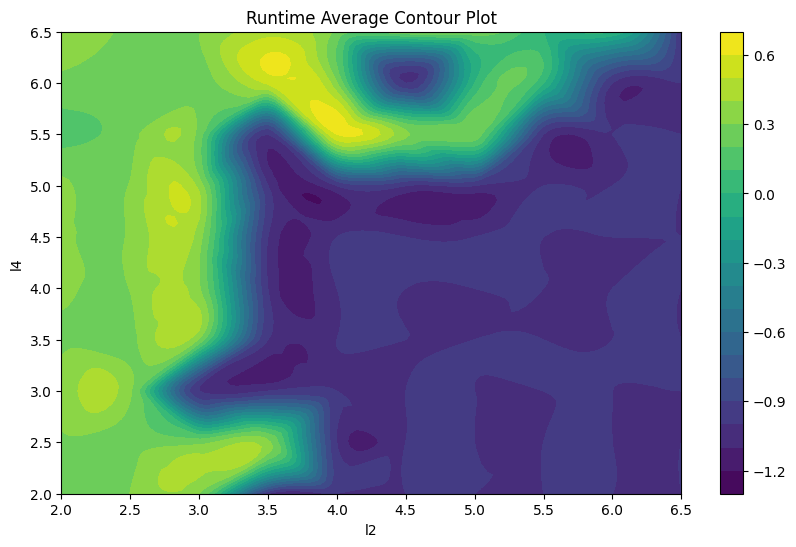

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Assuming runtime_df is your DataFrame
# Extract columns
l2 = runtime_df['l2']
l4 = runtime_df['l4']
runtime_avg = runtime_df['runtime_avg']

# Create a grid for contouring
l2_grid, l4_grid = np.meshgrid(
    np.linspace(l2.min(), l2.max(), 100),
    np.linspace(l4.min(), l4.max(), 100)
)

# Interpolate runtime_avg values onto the grid
runtime_avg_grid = griddata((l2, l4), runtime_avg, (l2_grid, l4_grid), method='cubic')

# Create the contour plot
plt.figure(figsize=(10, 6))
contour = plt.contourf(l2_grid, l4_grid, runtime_avg_grid, levels=20, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('l2')
plt.ylabel('l4')
plt.title('Runtime Average Contour Plot')
plt.show()


## Visualizing the Best Configuration

After identifying the optimal configuration for the four-bar linkage system (i.e., the combination of **l2** and **l4** that yields the highest **runtime_avg**), we proceed to visualize its behavior during the simulation. This visualization includes:
1. The same plots as discussed earlier to analyze the system's performance.
2. A video of the simulation to observe the system's motion and dynamics.


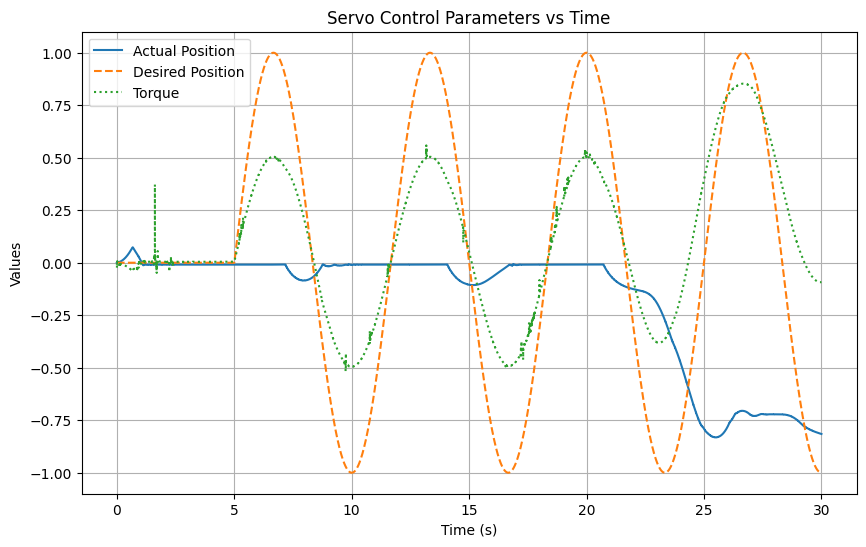

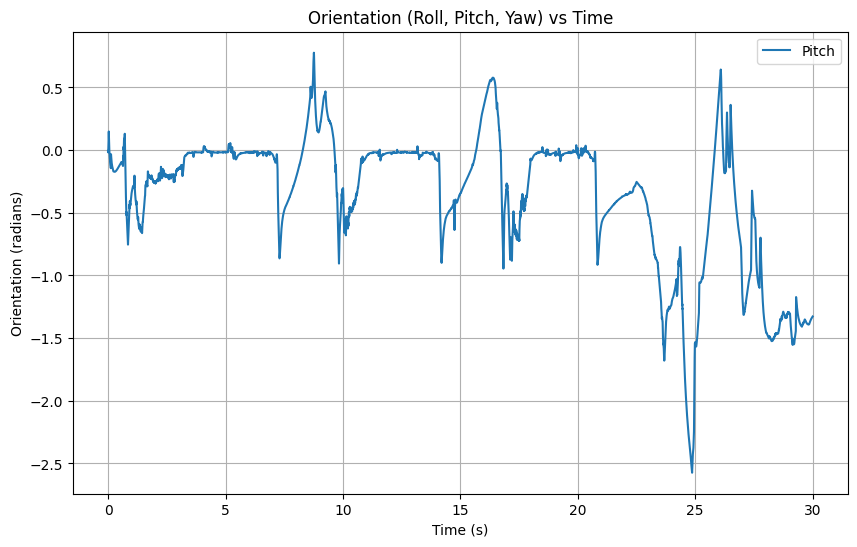

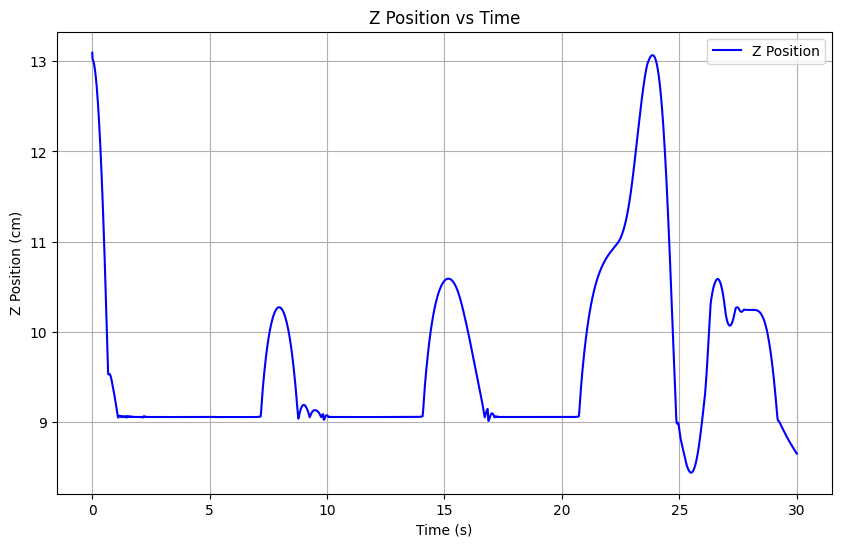

In [21]:
log_data = {
    "time": [],
    "actual": [],
    "desired": [],
    "torque": []
    }

orientation_log = {
        "time": [],
        "roll": [],
        "pitch": [],
        "yaw": []
    }

sitePos = {
            "time": [],
            "x": [],
            "y": [],
            "z": []
        }

runtime_avg , Flag = run_sim(l1 = 5 , l2 = l2_highest , l3 = 6, l4 = l4_highest , le = 10, show_video=True, plotting = True)

In [22]:
runtime_avg

np.float64(0.6014161096596427)

In [23]:
Flag

0

#### Experiments on the prototype using the optimized values

![Tracker software to analyze the prototype performance](Tracker_robot.png)


## Observations from the Y-Axis Data Over Time

### Key Insight
When analyzing the **y-axis data** over time, we can observe a distinct increase in its values that directly corresponds to the movement of the four-bar linkage system. This trend provides critical insights into the dynamics of the mechanism and confirms the system's functionality. 

---

### Observations
1. **Y-Axis Increase with Four-Bar Movement**:
   - The **y-axis data** shows noticeable increases during specific periods of time, indicating the displacement or motion of the system in the horizontal direction.
   - These increases align with the activation of the four-bar mechanism, suggesting that the linkage system is contributing significantly to the motion along the y-axis.

2. **Dynamic Behavior**:
   - This behavior matches the expected dynamics of the system, where the four-bar mechanism introduces predictable movements in response to control inputs.

3. **Consistency with MuJoCo Simulation**:
   - A similar performance has been observed in the MuJoCo simulation model, validating the fidelity of the simulated system to real-world dynamics.
   - The consistent trends between simulation and recorded data highlight the accuracy of the MuJoCo model in capturing the system's behavior and dynamics.

---

### Implications
1. **Validation of Model Dynamics**:
   - The observed y-axis behavior reinforces the effectiveness of the four-bar mechanism in achieving controlled, predictable motion.
   - The simulation's agreement with observed data validates the use of MuJoCo for modeling and optimizing the system.

2. **Performance Analysis**:
   - The y-axis data provides a reliable metric to analyze how well the system performs under different configurations, especially in terms of horizontal displacement and stability.

3. **Design Confirmation**:
   - The correlation between four-bar movement and y-axis data confirms that the current design effectively translates input motion into desired system behavior.

---



### Experiment on prototype with `l2` =  5, `l4` = 5

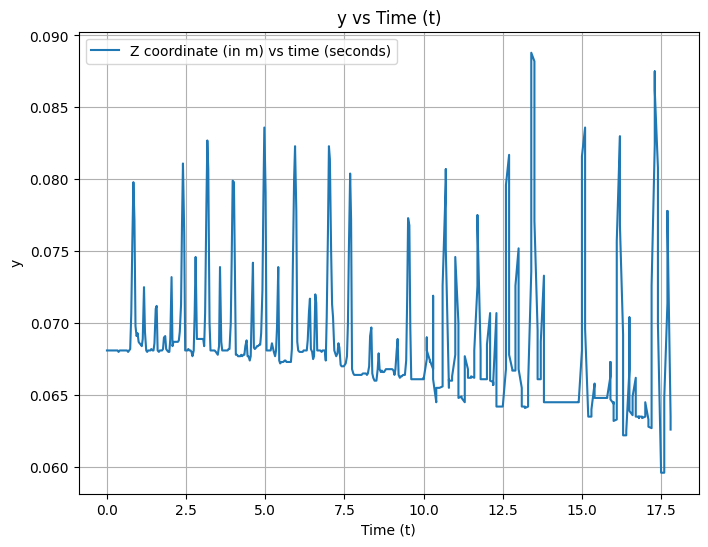

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('initial_data.csv')

# Plot y vs t
plt.figure(figsize=(8, 6))
plt.plot(df['t'], df['y'], label='Z coordinate (in m) vs time (seconds)')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('y vs Time (t)')
plt.grid(True)
plt.legend()
plt.show()


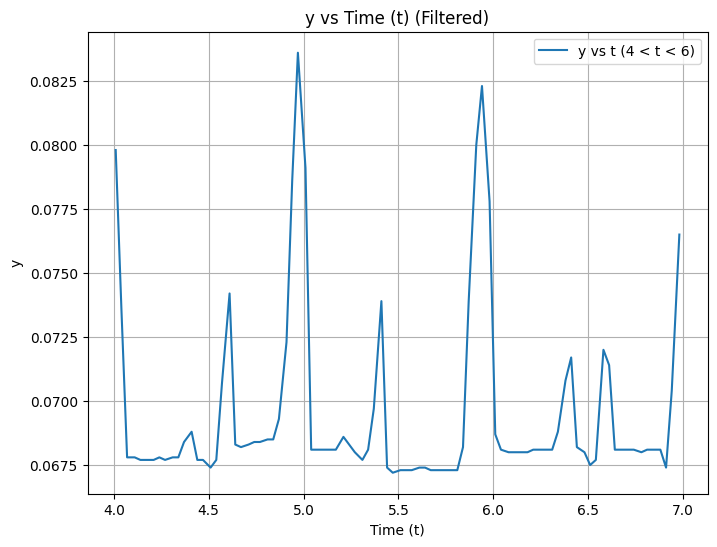

In [25]:
# Filter data where t > 4 and t < 6
filtered_df = df[(df['t'] > 4) & (df['t'] < 7)]

# Plot y vs t for the filtered data
plt.figure(figsize=(8, 6))
plt.plot(filtered_df['t'], filtered_df['y'], label='y vs t (4 < t < 6)')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('y vs Time (t) (Filtered)')
plt.grid(True)
plt.legend()
plt.show()

### Experiment on prototype with `l2` =  4, `l4` = 5.5

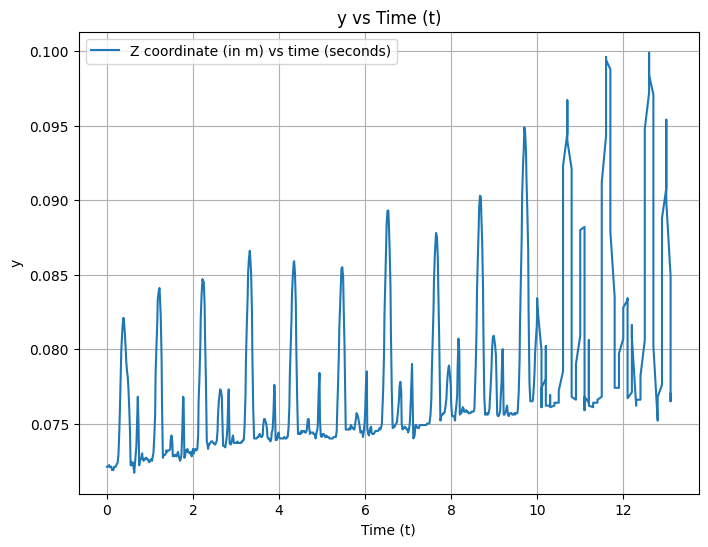

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('robot_data.csv')

# Plot y vs t
plt.figure(figsize=(8, 6))
plt.plot(df['t'], df['y'], label='Z coordinate (in m) vs time (seconds)')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('y vs Time (t)')
plt.grid(True)
plt.legend()
plt.show()


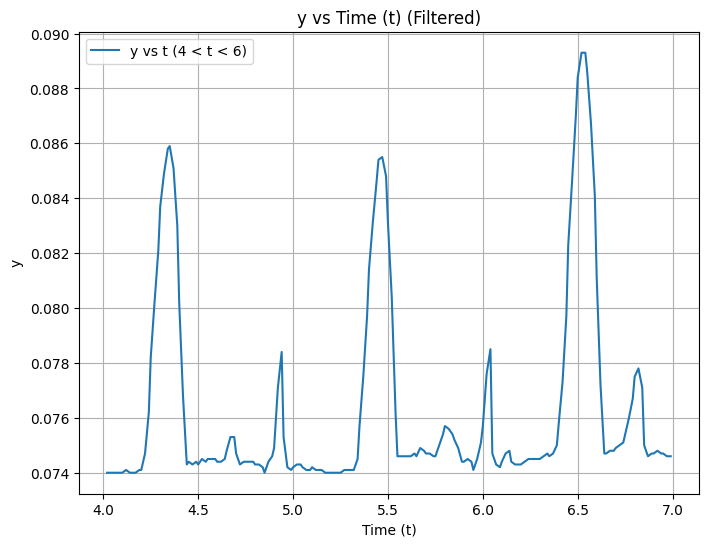

In [27]:
# Filter data where t > 4 and t < 6
filtered_df = df[(df['t'] > 4) & (df['t'] < 7)]

# Plot y vs t for the filtered data
plt.figure(figsize=(8, 6))
plt.plot(filtered_df['t'], filtered_df['y'], label='y vs t (4 < t < 6)')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('y vs Time (t) (Filtered)')
plt.grid(True)
plt.legend()
plt.show()

## Comparison of the Effect of Configuration Change on Prototype

### Experiment Overview
Two experiments were conducted to observe the effect of changing the four-bar mechanism configuration on the system's dynamics:
1. **Configuration 1**: **l2 = 5**, **l4 = 5**.
2. **Configuration 2**: **l2 = 4**, **l4 = 5.5**.

The results highlight how the system's dynamics are influenced by different configurations, particularly the behavior of the Z value (vertical displacement).

---

### Observations

1. **Configuration 1 (l2 = 5, l4 = 5)**:
   - The Z value exhibits sharper spikes during the experiment.
   - These spikes correspond to more abrupt changes in the vertical position, indicating heightened dynamic effects with this configuration.
   - Interestingly, despite the sharper spikes, the system did not tip over completely, contrary to initial expectations.

2. **Configuration 2 (l2 = 4, l4 = 5.5)**:
   - The Z value changes are smoother, suggesting a more stable dynamic response.
   - This configuration demonstrates reduced vertical displacement compared to Configuration 1.

---

### Insights

1. **Unexpected Stability of Configuration 1**:
   - It was initially expected that the system with **l2 = 5** and **l4 = 5** would tip over completely, marking a failed case.
   - However, this was not observed in the experiment. The system maintained stability, albeit with sharper Z spikes.

2. **Potential Reasons for Discrepancy**:
   - **Unmodeled Constraints**: The physical prototype may include additional constraints or factors not represented in the MuJoCo simulation. These could include structural stiffness, minor joint frictions, or material properties.
   - **Servo Behavior**: The servos on the prototype's wheels are not free-moving like those in the MuJoCo simulation. This resistance likely contributes to the system's ability to remain upright, even under more dynamic conditions.

3. **Effect of Four-Bar Configuration**:
   - Changes in the four-bar configuration (e.g., link lengths) directly influence the system’s dynamics. 
   - Shortening **l2** and lengthening **l4** (Configuration 2) resulted in smoother dynamics, highlighting the importance of link length ratios in achieving stability.

---

![Graph comparision](prototype_change.png)




## Comparison of Robot Body tipping: Prototype vs Simulation

The height of the robot body has been compared between the **physical prototype** (left) and the **simulated MuJoCo model** (right). This comparison provides valuable insights into how well the simulated system replicates the real-world behavior of the robot.


![Graph comparision](graph_compare.png)


## Reducing the Sim-to-Real Gap

To reduce the simulation-to-real (sim2real) gap and improve the fidelity of the simulated system to the real-life prototype, it is essential to model all physical aspects of the prototype with high accuracy. One critical area is **motor modeling**, where the simulated actuators must replicate the exact torque-speed characteristics, power limits, and response delays of the real motors. Accurate **joint stiffness and damping modeling** is also crucial, as these parameters dictate how the system absorbs and dissipates energy during movement. Variations in joint flexibility and resistance can significantly affect the dynamics, especially in a system with complex mechanisms like the four-bar linkage. Additionally, incorporating **friction modeling** for joints, surfaces, and actuators ensures the simulation accounts for resistive forces that are often present in physical systems. **Mass and inertia modeling** should be precise, capturing the true distribution of mass across the robot's components to reflect realistic dynamic responses. **Sensor noise** and **controller imperfections** should also be introduced into the simulation to mimic real-world uncertainties. By iteratively validating the simulation against experimental prototype data and refining these parameters, the sim2real gap can be minimized, enabling the simulation to serve as a reliable tool for optimization and design iteration.

---

## Assumptions and Sources of Error Between Simulation and Prototype

The primary sources of error contributing to the sim2real gap typically include **inaccurate physical modeling**, **simplifications in dynamic behaviors**, and **environmental effects**. Inaccurate modeling of actuators, such as neglecting motor delays, torque ripple can cause deviations in system performance. Similarly, assumptions about idealized joints with constant stiffness and damping may overlook real-world variations due to wear, lubrication, or material properties. **Friction forces**, particularly nonlinear effects like static friction (stiction) and dynamic friction, are often oversimplified in simulations, leading to discrepancies in motion profiles. Environmental factors, such as surface imperfections, vibrations, and air resistance, are difficult to model but can significantly impact the prototype’s behavior. Lastly, **sensor inaccuracies** in the prototype, including noise, calibration errors, and sampling delays, may cause data deviations that are not reflected in the simulation. Identifying and addressing these sources of error is critical to bridging the gap between simulation and real-world performance.


# Manufacturing Details

### Robot Design and Fabrication Process

#### Initial Design Iteration
The initial design of the robot was created using **SolidWorks** while simultaneously working on the Mujoco model. The design parameters were agreed upon to maintain consistency between the SolidWorks and Mujoco models. However, several issues arose with the SolidWorks parts, including:

- Difficulty in exporting parts as **DXF files** for use with the vinyl cutter.
- Challenges in mating sheet metal parts effectively, such as ensuring proper alignment and tolerance.
- Difficulty in achieving a modular and adaptable structure due to software limitations.

![Initial Design - SolidWorks](solidworks_design_image.png)

#### Transition to LibreCAD
Due to the limitations encountered with SolidWorks, we decided to shift to **LibreCAD** for designing DXF files directly. This transition allowed greater flexibility for adjustments, although it introduced challenges such as:

- Limited advanced design features.
- Manual adjustments and multiple iterations required to achieve desired accuracy.
- Steeper learning curve for some team members unfamiliar with the software.

Despite these difficulties, the team successfully created designs suitable for fabrication after extensive trials.

![DXF Output - LibreCAD](librecad_dxf_image.png)
![Four-Bar Cut Process 1](cut1.png)
![Four-Bar Cut Process 2](cut2.png)
![Four-Bar Final Cut](final_cut.png)

#### Material Selection and Testing
To ensure the optimal balance between sturdiness and flexibility, various materials were tested during the design process:

1. **Cardstock Paper**
   - Thickness: 0.267 mm
   - GSM: ~230
   - Extensively used for early prototypes to fine-tune dimensions.

2. **Illustration Board/Cardboard**
   - Thickness: 1.588 mm
   - GSM: ~140
   - Used for more robust prototypes and structural elements.

3. **Multilayered Materials**
   - Composition: Cardboard + Adhesive + Mylar + Adhesive + Cardstock Paper
   - Purpose: Achieve a combination of sturdiness and flexibility. The base and top layers differed to balance these properties.

#### Fabrication Process

1. **Vinyl Cutter Testing**
   Initial tests were conducted using a vinyl cutter provided by the professor to verify the designs. Cardstock paper was primarily used during this stage.

2. **Laser Cutting**
   After multiple iterations and tweaks, the finalized designs were prepared for laser cutting, allowing precise and clean cuts.

3. **Assembly**
   - The flanges were glued using **Elmer's Glue-All**, ensuring secure connections.
   - M2 screws were used for modular assembly, enabling configuration changes and easy disassembly.
   - Servo mounts, screw holes, and cable cutouts were integrated into the design for efficient functionality.

![Circuitry Assembly](circuit.jpeg)

#### Experiment Setup

1. **Setup Configuration**
   - A **DJI Gimbal** was used to stabilize the camera during testing.
   - The robot was placed on a small table, with the distance between the camera and the tracker sign precisely measured at 35 cm.

2. **Data Collection and Analysis**
   - The experiment was recorded to capture the robot's movement and performance.
   - Analysis was conducted using the **Tracker software**, which provided detailed insights and final results for performance evaluation.

#### Future Work ( V2 of our robot )

1. **Material Analysis and Weight Distribution**
   - To address weight and balance issues, we plan to systematically analyze the properties of the materials used in the robot's construction. This will include evaluating density, flexibility, and tensile strength to optimize performance.
   - The insights gained from this analysis will inform adjustments to the four-bar mechanism, ensuring it remains robust and efficient under the revised weight distribution.
   - We will simulate these changes in both Mujoco and LibreCAD to streamline the integration process.

2. **Wheeled Mobility Enhancement**
   - The robot's mobility will be enhanced by integrating wheels designed to assist in lifting and stability. To achieve this:
     - We will evaluate wheel materials and sizes to ensure compatibility with the robot's current design and weight.
     - Servo motors will be integrated to drive the wheels, allowing precise control over movement and lift angles.
     - A combination of practical testing and simulations will be used to maintain consistent lift status during operation.
   - This modification is expected to improve the robot's adaptability and enable smoother transitions during various maneuvers.

---

